# Load DeepFly3D Data

In [82]:
%load_ext autoreload
%autoreload 2
from src.load import *
import yaml
import logging
from imp import reload
reload(logging)

# decleare data parameters
par = {'data_dir'       : '/data/LiftPose3D/fly_tether/data_DF3D', # change the path 
       'out_dir'        : './out',
       'train_subjects' : [1,2,3,4,5],
       'test_subjects'  : [6,7],
       'actions'        : ['all'],
       'cam_id'         : [2,5]}

# merge with training parameters
par = {**yaml.full_load(open('param.yaml', "rb"))["data"], **par}

# Load 2D data
train_2d = load_2D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["train_subjects"],
    actions=par["actions"],
)
test_2d = load_2D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["test_subjects"],
    actions=par["actions"],
)

# Load 3D data
train_3d, _, rcams_train = load_3D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["train_subjects"],
    actions=par["actions"],
)
test_3d, _, rcams_test = load_3D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["test_subjects"],
    actions=par["actions"],
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Train LiftPose3D Network on DeepFly3D Data

In [21]:
from liftpose.main import train as lp3d_train
from liftpose.main import test as lp3d_test
# TODO it does not make sense to input dictionary, it should be two numpy arrays instead, or at least dictionary of same size
lp3d_train(train_2d, test_2d, train_3d, test_3d, rcams_train, rcams_test, 
      par['roots'], par['targets'], 2, par["out_dim"], par['out_dir'])

2020-12-20 08:41:46,532:INFO:Saving pre-processed 2D data at /home/user/Desktop/LiftPose3D/examples/fly_tether/out/stat_2d.pth.tar.
2020-12-20 08:41:48,389:INFO:Saving pre-processed 3D data at /home/user/Desktop/LiftPose3D/examples/fly_tether/out/stat_3d.pth.tar.
2020-12-20 08:41:49,921:INFO:Starting training model
2020-12-20 08:41:49,925:DEBUG:
==================Options=================
2020-12-20 08:41:49,926:DEBUG:{   'batch_size': 64,
    'data_dir': '/home/user/Desktop/LiftPose3D/examples/fly_tether/out',
    'dropout': 0.5,
    'epochs': 200,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 100000,
    'lr_gamma': 0.96,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/home/user/Desktop/LiftPose3D/examples/fly_tether/out',
    'out_dir': '/home/user/Desktop/LiftPose3D/examples/fly_tether/out',
    'predict': False,
    'procrustes': False,
    'resume': False,
    'test': False}


  0%|          | 0/11053 [00:00<?, ?it/s]

>>> epoch: 1 | lr: 0.00100


  0%|          | 0/11053 [00:00<?, ?it/s]

>>> test error: 0.06316868960857391 <<<
>>> epoch: 2 | lr: 0.00100


  0%|          | 0/11053 [00:00<?, ?it/s]

>>> test error: 0.05749255046248436 <<<
>>> epoch: 3 | lr: 0.00100


  0%|          | 0/11053 [00:00<?, ?it/s]

>>> test error: 0.053613901138305664 <<<
>>> epoch: 4 | lr: 0.00100


  0%|          | 0/11053 [00:00<?, ?it/s]

>>> test error: 0.05254906415939331 <<<
>>> epoch: 5 | lr: 0.00100


  0%|          | 0/11053 [00:00<?, ?it/s]

>>> test error: 0.052096862345933914 <<<
>>> epoch: 6 | lr: 0.00100


  0%|          | 0/11053 [00:00<?, ?it/s]

>>> test error: 0.049836646765470505 <<<
>>> epoch: 7 | lr: 0.00100


  0%|          | 0/11053 [00:00<?, ?it/s]

>>> test error: 0.05005735158920288 <<<
>>> epoch: 8 | lr: 0.00100


  0%|          | 0/11053 [00:00<?, ?it/s]

>>> test error: 0.04968129098415375 <<<
>>> epoch: 9 | lr: 0.00100


  0%|          | 0/11053 [00:00<?, ?it/s]

>>> test error: 0.05045212432742119 <<<
>>> epoch: 10 | lr: 0.00100


  0%|          | 0/11053 [00:00<?, ?it/s]

>>> test error: 0.048586249351501465 <<<
>>> epoch: 11 | lr: 0.00096


  0%|          | 0/11053 [00:00<?, ?it/s]

>>> test error: 0.04769899323582649 <<<
>>> epoch: 12 | lr: 0.00096


  0%|          | 0/11053 [00:00<?, ?it/s]

>>> test error: 0.04894165322184563 <<<
>>> epoch: 13 | lr: 0.00096


  0%|          | 0/11053 [00:00<?, ?it/s]

>>> test error: 0.048920586705207825 <<<
>>> epoch: 14 | lr: 0.00096


  0%|          | 0/11053 [00:00<?, ?it/s]

>>> test error: 0.04772130772471428 <<<
>>> epoch: 15 | lr: 0.00096


  0%|          | 0/11053 [00:00<?, ?it/s]

>>> test error: 0.04847876355051994 <<<
>>> epoch: 16 | lr: 0.00096


  0%|          | 0/11053 [00:00<?, ?it/s]

>>> test error: 0.046560853719711304 <<<
>>> epoch: 17 | lr: 0.00096


  0%|          | 0/11053 [00:00<?, ?it/s]

>>> test error: 0.04801526665687561 <<<
>>> epoch: 18 | lr: 0.00096


  4%|▍         | 467/11053 [00:04<01:31, 115.24it/s]Exception in thread Thread-89:
Traceback (most recent call last):
  File "/home/user/anaconda3/envs/lf3d/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/home/user/anaconda3/envs/lf3d/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/user/anaconda3/envs/lf3d/lib/python3.7/site-packages/torch/utils/data/_utils/pin_memory.py", line 25, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/home/user/anaconda3/envs/lf3d/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/home/user/anaconda3/envs/lf3d/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 294, in rebuild_storage_fd
    fd = df.detach()
  File "/home/user/anaconda3/envs/lf3d/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(sel

KeyboardInterrupt: 

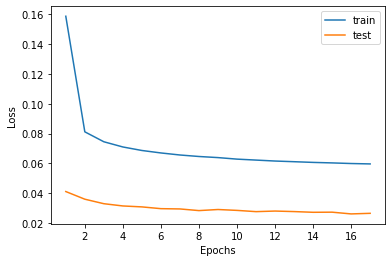

In [22]:
from liftpose.plot import read_log_train, plot_log_train
import matplotlib.pyplot as plt
# TODO why large gap between train and test?
epoch, lr, loss_train, loss_test, err_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)

# Run Trained LiftPose3D Network on the Test Data

In [23]:
# TODO test prints as log instead
# TODO pass arguments if we want to test it on the data that is not trained on
lp3d_test(par['out_dir'])

  0%|          | 0/594 [00:00<?, ?it/s]


>>> loading data
>>> input dimension: 24
>>> output dimension: 36
>>> total params: 4.27M
>>> loading ckpt from './out/ckpt_best.pth.tar'
>>> ckpt loaded (epoch: 16 | err: 0.046560853719711304)


100%|██████████| 594/594 [00:01<00:00, 326.77it/s]


>>> test error: 0.046560853719711304 <<<
/home/user/Desktop/LiftPose3D/examples/fly_tether/out/test_results.pth.tar
0.0466	

SystemExit: 

# Visualize Predictions

In [83]:
# TODO we are losing correspondence between exp names and final predictions, we should keep it!
from liftpose.postprocess import load_test_results
test_3d, test_3d_pred = load_test_results(par['out_dir'])

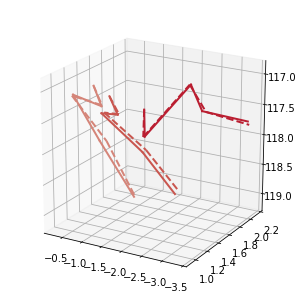

In [125]:
import networkx as nx
from liftpose.plot import plot_3d_graph
pos_pred, pos_tar = [], []

thist = 7
pos_pred, pos_tar = [], []
t = 900
for j in range(test_3d_pred.shape[1]//3):
    tmin = max(0,t-thist+1)
    pos_pred.append((test_3d_pred[tmin:(t+1), 3*j], test_3d_pred[tmin:(t+1), 3*j+1], test_3d_pred[tmin:(t+1), 3*j+2]))
    pos_tar.append((test_3d[tmin:(t+1), 3*j], test_3d[tmin:(t+1), 3*j+1], test_3d[tmin:(t+1), 3*j+2]))

pos_pred, pos_tar = np.array(pos_pred), np.array(pos_tar)
#.plot_trailing_points(pos_pred[legtips,:,:],min(thist,t+1),ax)

G=nx.Graph()
G.add_edges_from(np.array(par['bones'])[:12])
G.add_nodes_from(np.arange(par['ndims']))
print(G)

fig = plt.figure(figsize=plt.figaspect(1))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=200, azim=60)

limb_id = [i for i in range(6) for j in range(5)]
nodes = [i for i in range(30)]

colors = [[186,30,49], [201,86,79], [213,133,121], #RF, RM, RH
          [15,115, 153], [26,141, 175], [117,190,203] #LF, LM, LH
          ]

edge_colors = [[x / 255.0 for x in colors[i]] for i in limb_id]

#plot skeleton
plot_3d_graph(G, pos_tar[:,:,-1], ax, color_edge=edge_colors)
plot_3d_graph(G, pos_pred[:,:,-1], ax, color_edge=edge_colors, style='--')